In [1]:
import sys
sys.path.append("../")

In [2]:
from data_utils import load_mnist, load_usps

source_train_loader, source_test_loader = load_mnist(img_size=32, augment=True, batch_size=64, shuffle=True, num_workers=2) 
target_train_loader, target_test_loader = load_usps(img_size=32, augment=True, batch_size=64, shuffle=True, num_workers=2)

In [3]:
import torch.nn as nn
import torch.optim as optim 
from models import DomainAdaptationNetwork, Decoder, DomainAdaptationEncoder

embedder = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=50, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.BatchNorm2d(50),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=50, out_channels=75, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.BatchNorm2d(75),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=75, out_channels=100, kernel_size=3, padding=1),
    nn.ReLU(True),
    nn.BatchNorm2d(100),
    nn.ReLU(True),
    nn.Flatten(),
    nn.Linear(in_features=6400, out_features=512),
    nn.ReLU(True)
)
conv_feat_size =(100,8,8)

encoder = DomainAdaptationEncoder(embedder=embedder, latent_space_dim=150, nb_channels=1)
decoder_source = Decoder(latent_space_dim=300, conv_feat_size=conv_feat_size, nb_channels=1)
decoder_target = Decoder(latent_space_dim=300, conv_feat_size=conv_feat_size, nb_channels=1)
model = DomainAdaptationNetwork(encoder, decoder_source, decoder_target).cuda()
optimizer = optim.RMSprop(model.parameters(), lr=5e-4, weight_decay=0.001)

In [4]:
import numpy as np
from train import train_domain_adaptation

epochs = 50
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
betas = np.linspace(0, 5, epochs)
train_domain_adaptation(model, 
                        optimizer, 
                        source_train_loader, 
                        target_train_loader,
                        epochs=epochs, 
                        betas=betas, 
                        gamma=0.5, 
                        delta=1, 
                        scheduler=scheduler)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-upqku585 because the default path (/home/david.bertoin/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
  0%|                                                                                                                               | 0/50 [00:00<?, ?it/s]/home/david.bertoin/.conda/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:756: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
epoch:49 curr

0.9895761898230695

0.992319297764367


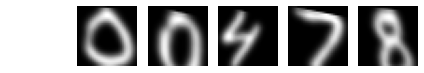

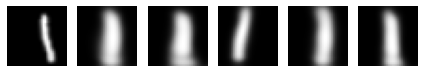

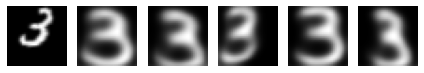

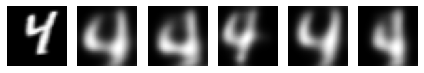

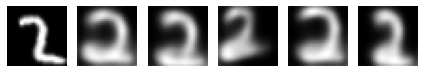

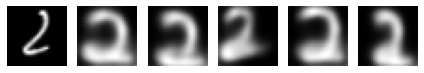

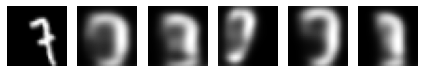

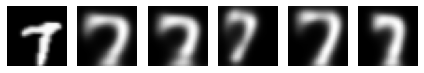

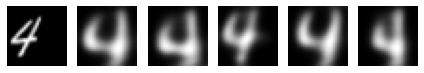

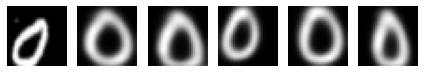

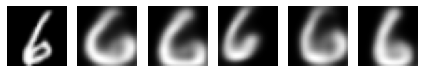

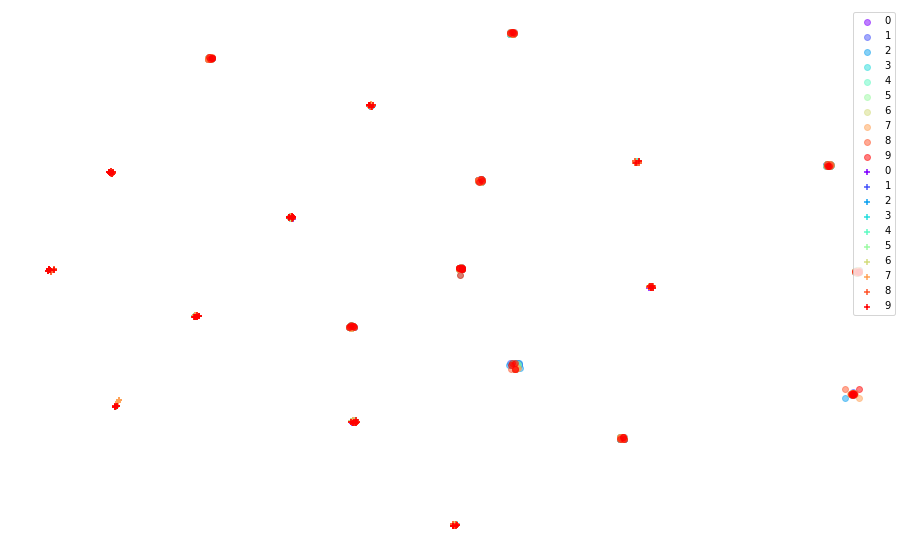

In [5]:
from utils import test_network, plot_target_cross_domain_swapping, plot_tsne
model.eval()
print(test_network(model, target_test_loader)  )
model.train();
plot_target_cross_domain_swapping(model, source_train_loader, target_train_loader)
plot_tsne(model, source_train_loader, target_train_loader, 64, 150)